In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from pycox.models import DeepHitSingle

from pycox.evaluation import EvalSurv
from pycox.simulations import SimStudyLinearPH

import torch
import torchtuples as tt

# Read data

In [2]:
df_train = pd.read_csv('train.csv')
df_train = pd.DataFrame(df_train)

df_test = pd.read_csv('test.csv')
df_test = pd.DataFrame(df_test)

In [3]:
df_train.head()

,Sex,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage,duration,event
0,Male,41,65,Ileocecal Junction,II,29,1,T3,N1a,M0,IIIB,110,0
1,Male,54,95,Ascending Colon,II,37,0,T4a,N0,M0,IIB,107,0
2,Female,78,65,Sigmoid Colon,II,20,2,T4b,N1b,M0,IIIC,106,0
3,Female,33,150,"Large Intestine, NOS",II,9,0,T4a,N0,M0,IIB,105,0
4,Male,58,100,Descending Colon,III,6,1,T4a,N1a,M0,IIIB,102,0


In [4]:
# to label encoding categorical variables
le = LabelEncoder() #label encoder
cat_list = ['Sex','Site', 'Grade', 'T', 'N', 'M', 'Stage'] #list of categorical variables
for cat in cat_list:
    df_train[cat] = le.fit_transform(df_train[cat])
    df_test[cat] = le.fit_transform(df_test[cat])

df_train.head()

,Sex,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage,duration,event
0,1,41,65,3,1,29,1,2,2,0,7,110,0
1,1,54,95,0,1,37,0,4,0,0,3,107,0
2,0,78,65,7,1,20,2,5,3,0,8,106,0
3,0,33,150,4,1,9,0,4,0,0,3,105,0
4,1,58,100,1,2,6,1,4,2,0,7,102,0


In [5]:
# function to get targets variable
get_target = lambda df: (df['duration'].values, df['event'].values)

# to standardize and get dependent variables 
cols_standardize = ['Age', 'Size', 'Lymph.nodes.examined', 'Lymph.nodes.positive'] # list of variables for standardization
cols_leave = ['Sex','Site', 'Grade', 'T', 'N', 'M', 'Stage'] #categorical variables 

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

num_durations = 10

labtrans = DeepHitSingle.label_transform(num_durations)

y_train = labtrans.fit_transform(*get_target(df_train))
y_test = labtrans.transform(*get_target(df_test))

train = (x_train, y_train)
val = (x_test, y_test)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

# Neural Network

In [64]:
in_features = x_train.shape[1]
num_nodes = [16,16]
# out_features = 1
out_features = labtrans.out_features
batch_norm = True
dropout = 0.3
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model_cox = DeepHitSingle(net, tt.optim.Adam(lr=0.01,amsgrad=True),alpha=0.2, sigma=0.1, duration_index=labtrans.cuts) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks,val_data =val)


0:	[0s / 0s],		train_loss: 0.9075,	val_loss: 0.5403
1:	[0s / 0s],		train_loss: 0.6828,	val_loss: 0.5418
2:	[0s / 0s],		train_loss: 0.6374,	val_loss: 0.5365
3:	[0s / 0s],		train_loss: 0.5950,	val_loss: 0.5282
4:	[0s / 0s],		train_loss: 0.7274,	val_loss: 0.5180
5:	[0s / 0s],		train_loss: 0.6261,	val_loss: 0.5137
6:	[0s / 0s],		train_loss: 0.6014,	val_loss: 0.5120
7:	[0s / 0s],		train_loss: 0.5841,	val_loss: 0.5095
8:	[0s / 0s],		train_loss: 0.5576,	val_loss: 0.5083
9:	[0s / 0s],		train_loss: 0.5508,	val_loss: 0.5075
10:	[0s / 0s],		train_loss: 0.5920,	val_loss: 0.5085
11:	[0s / 0s],		train_loss: 0.5632,	val_loss: 0.5116
12:	[0s / 0s],		train_loss: 0.5754,	val_loss: 0.5167
13:	[0s / 0s],		train_loss: 0.5606,	val_loss: 0.5168
14:	[0s / 0s],		train_loss: 0.5514,	val_loss: 0.5130
15:	[0s / 0s],		train_loss: 0.5576,	val_loss: 0.5163
16:	[0s / 0s],		train_loss: 0.5647,	val_loss: 0.5144
17:	[0s / 0s],		train_loss: 0.5532,	val_loss: 0.5131
18:	[0s / 0s],		train_loss: 0.5931,	val_loss: 0.5250
19:

0.728065674704977

<Figure size 864x864 with 0 Axes>

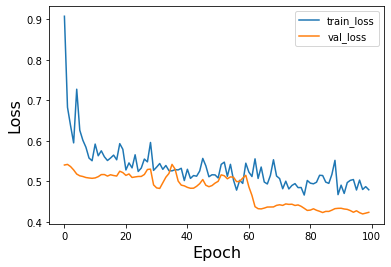

In [65]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
#model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.interpolate(10).predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, durations_test, events_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.18663032896227716

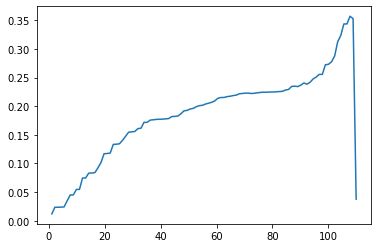

In [66]:
# integrated_brier_score at all
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

# Internal validation

In [67]:
# c-index at  all
durations_test0, events_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0,durations_test0, events_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.6850559326895497

0.37005175522811995

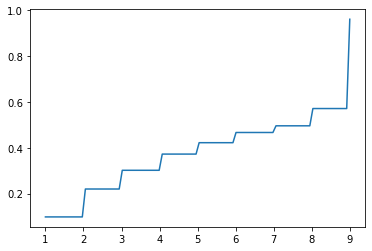

In [68]:
# brier score at all
time_grid0 = np.linspace(durations_test0.min(), durations_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [70]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.6890251868638235
The C-index Low 95% CI:0.6867746049460567
The C-index High 95% CI:0.6912757687815904


In [71]:
# External
ex_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.6493497256669843
The C-index Low 95% CI:0.6465783206150058
The C-index High 95% CI:0.6521211307189629


# Save

In [72]:
model_cox.save_model_weights('myweights_DeepHit.pt')

# LASSO var

In [73]:
df_train_lasso = df_train[["Age","Size","Site","Grade","Lymph.nodes.examined","Lymph.nodes.positive","T","N","M","Stage"]]
df_test_lasso = df_test[["Age","Size","Site","Grade","Lymph.nodes.examined","Lymph.nodes.positive","T","N","M","Stage"]]
df_train_lasso.head()

,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage
0,41,65,3,1,29,1,2,2,0,7
1,54,95,0,1,37,0,4,0,0,3
2,78,65,7,1,20,2,5,3,0,8
3,33,150,4,1,9,0,4,0,0,3
4,58,100,1,2,6,1,4,2,0,7


In [77]:

cols_standardize = ['Age', 'Size', 'Lymph.nodes.examined', 'Lymph.nodes.positive'] # list of variables for standardization
cols_leave = ['Site', 'Grade', 'T', 'N', 'M', 'Stage'] #categorical variables 

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train_lasso).astype('float32')
x_test = x_mapper.transform(df_test_lasso).astype('float32')

train = (x_train, y_train)
val = (x_test, y_test)

In [144]:
in_features = x_train.shape[1]
num_nodes = [32,16]
# out_features = 1
out_features = labtrans.out_features
batch_norm = True
dropout = 0.4
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model_cox = DeepHitSingle(net, tt.optim.Adam(lr=0.01,amsgrad=True),alpha=0.2, sigma=0.1, duration_index=labtrans.cuts) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks,val_data =val)


0:	[0s / 0s],		train_loss: 1.0564,	val_loss: 0.5840
1:	[0s / 0s],		train_loss: 0.7356,	val_loss: 0.5175
2:	[0s / 0s],		train_loss: 0.6749,	val_loss: 0.5052
3:	[0s / 0s],		train_loss: 0.6907,	val_loss: 0.5029
4:	[0s / 0s],		train_loss: 0.5777,	val_loss: 0.5027
5:	[0s / 0s],		train_loss: 0.6029,	val_loss: 0.4985
6:	[0s / 0s],		train_loss: 0.5663,	val_loss: 0.4957
7:	[0s / 0s],		train_loss: 0.5681,	val_loss: 0.4954
8:	[0s / 0s],		train_loss: 0.6193,	val_loss: 0.4950
9:	[0s / 0s],		train_loss: 0.5876,	val_loss: 0.4950
10:	[0s / 0s],		train_loss: 0.5602,	val_loss: 0.4911
11:	[0s / 0s],		train_loss: 0.5822,	val_loss: 0.4864
12:	[0s / 0s],		train_loss: 0.5756,	val_loss: 0.4871
13:	[0s / 0s],		train_loss: 0.5660,	val_loss: 0.4942
14:	[0s / 0s],		train_loss: 0.5777,	val_loss: 0.5160
15:	[0s / 0s],		train_loss: 0.5454,	val_loss: 0.5644
16:	[0s / 0s],		train_loss: 0.5609,	val_loss: 0.6093
17:	[0s / 0s],		train_loss: 0.5273,	val_loss: 0.6692
18:	[0s / 0s],		train_loss: 0.5539,	val_loss: 0.6336
19:

0.6849666495638789

<Figure size 864x864 with 0 Axes>

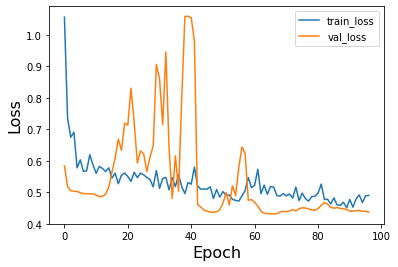

In [145]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
#model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.interpolate(10).predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, durations_test, events_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.18031312080645803

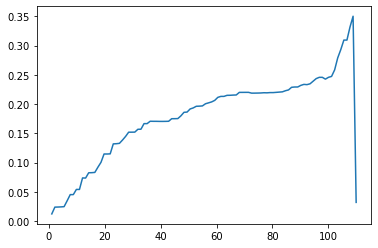

In [146]:
# integrated_brier_score at all
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [147]:
# c-index at  all
durations_test0, events_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0,durations_test0, events_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.6310593747012143

0.3628235465527916

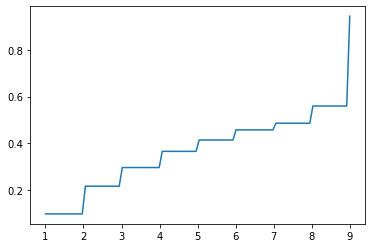

In [148]:
# brier score at all
time_grid0 = np.linspace(durations_test0.min(), durations_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [149]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.6305947362991661
The C-index Low 95% CI:0.6281951533186404
The C-index High 95% CI:0.6329943192796917


In [150]:
# External
ex_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.6788302602754203
The C-index Low 95% CI:0.675854878348288
The C-index High 95% CI:0.6818056422025526


# TNM

In [155]:
df_train_tnm = df_train[["T","N","M","Stage"]]
df_test_tnm = df_test[["T","N","M","Stage"]]
df_train_tnm.head()

,T,N,M,Stage
0,2,2,0,7
1,4,0,0,3
2,5,3,0,8
3,4,0,0,3
4,4,2,0,7


In [156]:
cols_leave = ['T', 'N', 'M', 'Stage'] #categorical variables 
leave = [(col, None) for col in cols_leave]
x_mapper = DataFrameMapper(leave)

x_train = x_mapper.fit_transform(df_train_tnm).astype('float32')
x_test = x_mapper.transform(df_test_tnm).astype('float32')

train = (x_train, y_train)
val = (x_test, y_test)

In [195]:
in_features = x_train.shape[1]
num_nodes = [64,64]
# out_features = 1
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model_cox = DeepHitSingle(net, tt.optim.Adam(lr=0.01,amsgrad=True),alpha=0.2, sigma=0.1, duration_index=labtrans.cuts) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks,val_data =val)


0:	[0s / 0s],		train_loss: 0.9567,	val_loss: 0.5472
1:	[0s / 0s],		train_loss: 0.6670,	val_loss: 0.5692
2:	[0s / 0s],		train_loss: 0.6582,	val_loss: 0.5224
3:	[0s / 0s],		train_loss: 0.5806,	val_loss: 0.5188
4:	[0s / 0s],		train_loss: 0.5790,	val_loss: 0.4925
5:	[0s / 0s],		train_loss: 0.5716,	val_loss: 0.4951
6:	[0s / 0s],		train_loss: 0.5527,	val_loss: 0.4895
7:	[0s / 0s],		train_loss: 0.5604,	val_loss: 0.4849
8:	[0s / 0s],		train_loss: 0.5452,	val_loss: 0.4751
9:	[0s / 0s],		train_loss: 0.5448,	val_loss: 0.4698
10:	[0s / 0s],		train_loss: 0.5497,	val_loss: 0.4765
11:	[0s / 0s],		train_loss: 0.5314,	val_loss: 0.4790
12:	[0s / 0s],		train_loss: 0.5232,	val_loss: 0.4641
13:	[0s / 0s],		train_loss: 0.5058,	val_loss: 0.4504
14:	[0s / 0s],		train_loss: 0.5235,	val_loss: 0.4627
15:	[0s / 0s],		train_loss: 0.5474,	val_loss: 0.4604
16:	[0s / 0s],		train_loss: 0.5489,	val_loss: 0.4537
17:	[0s / 0s],		train_loss: 0.5109,	val_loss: 0.4618
18:	[0s / 0s],		train_loss: 0.5034,	val_loss: 0.4580
19:

0.6777834787070293

<Figure size 864x864 with 0 Axes>

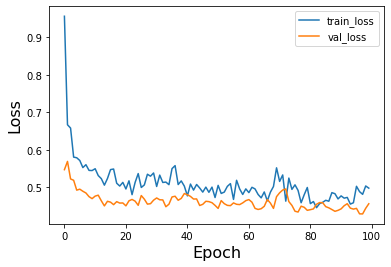

In [196]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
#model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.interpolate(10).predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, durations_test, events_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.18585855524700515

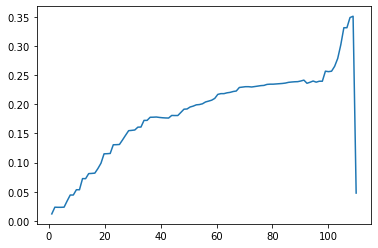

In [197]:
# integrated_brier_score at all
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [198]:
# c-index at  all
durations_test0, events_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0,durations_test0, events_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.4755593268954967

0.379693686408259

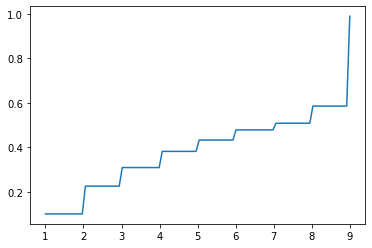

In [199]:
# brier score at all
time_grid0 = np.linspace(durations_test0.min(), durations_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [200]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.4783407760496456
The C-index Low 95% CI:0.47562941041397105
The C-index High 95% CI:0.4810521416853201


In [201]:
# External
ex_tem = []
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.41333200269193054
The C-index Low 95% CI:0.41049798464553205
The C-index High 95% CI:0.41616602073832903
